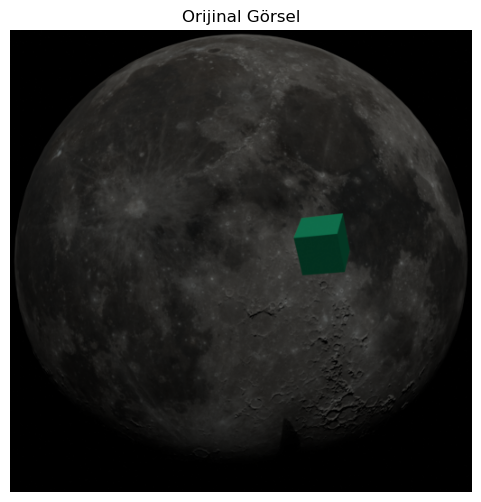

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Orijinal görseli yeniden oku
img_original = cv2.imread("anomaly.png")
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
img2 = img_original.copy()

# Görseli göster
plt.figure(figsize=(6, 6))
plt.imshow(img_original)
plt.title("Orijinal Görsel")
plt.axis('off')
plt.show()

Kaydedildi: E:\Blender_Videos\Anomaly_detection.png
Kaydedildi: E:\Blender_Videos\Anomaly_vertical.png


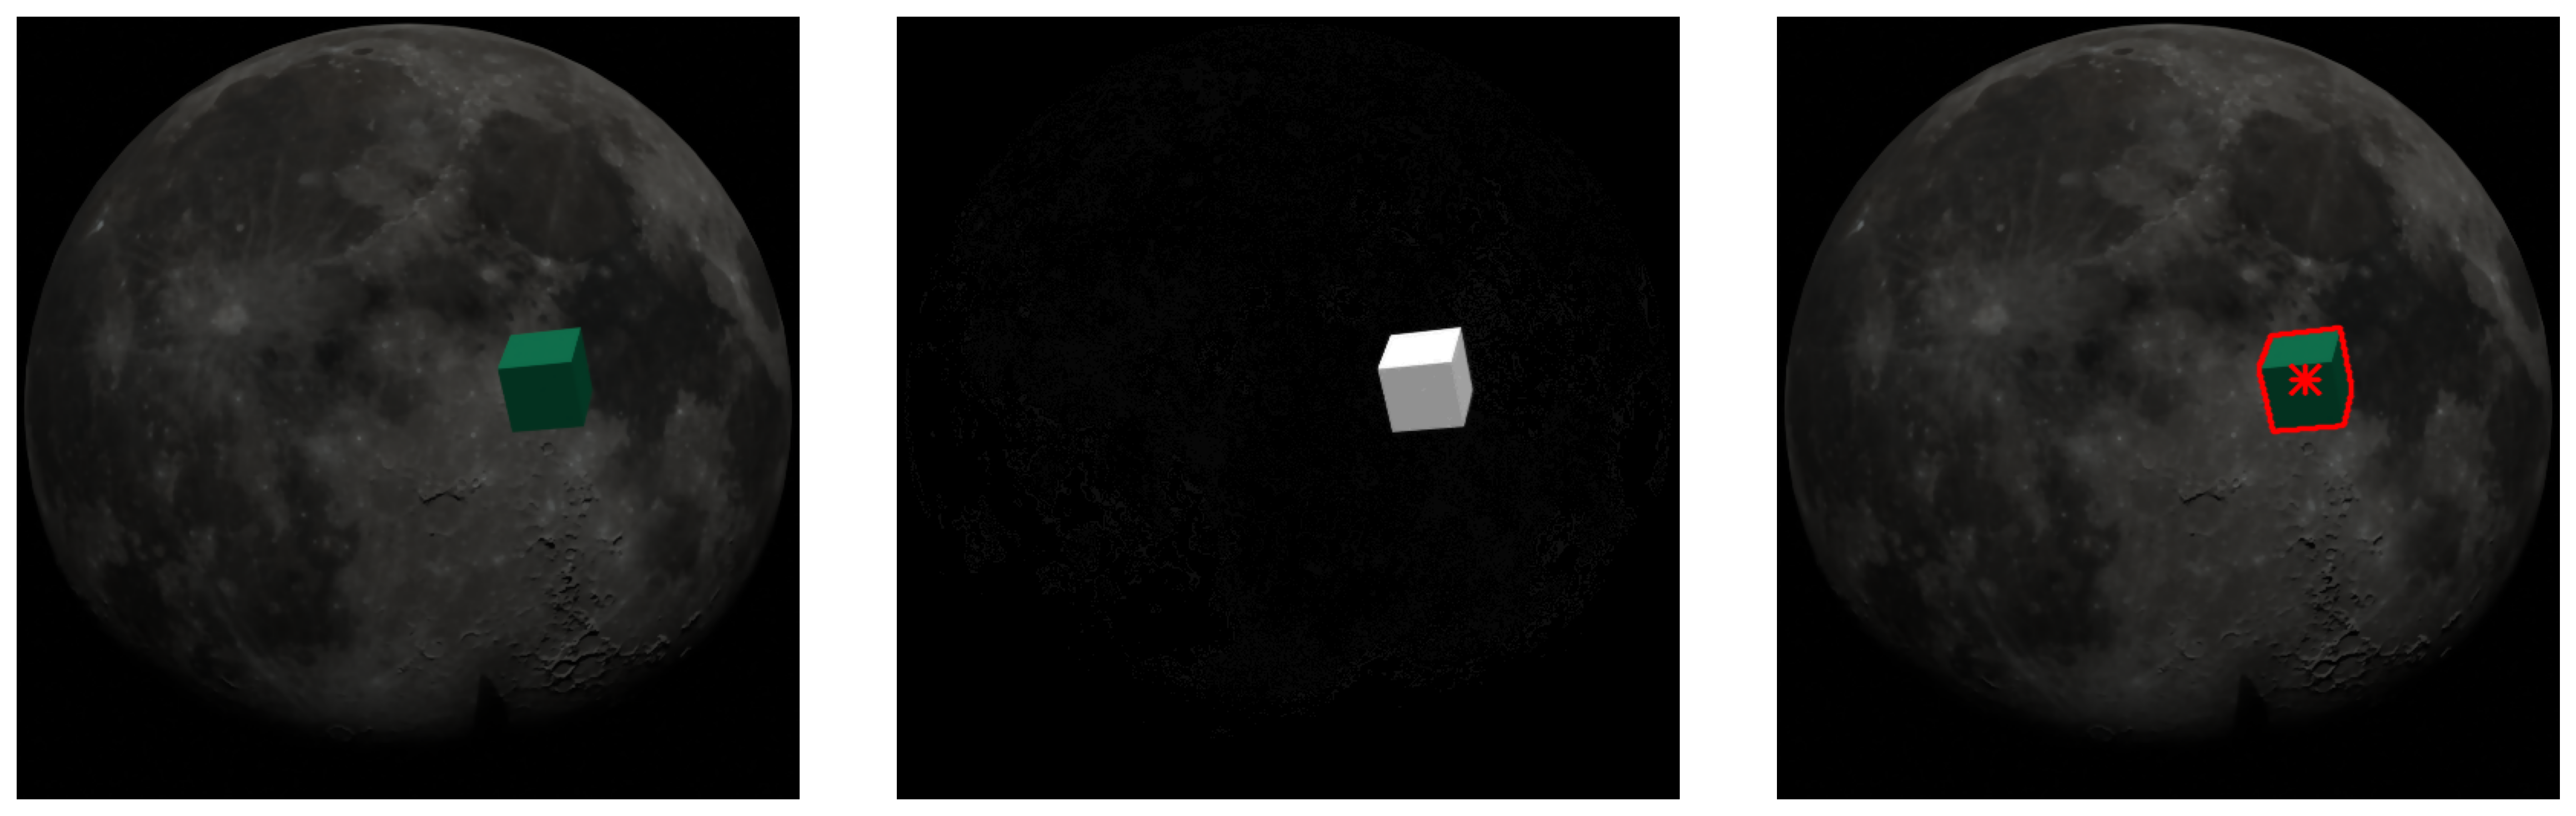

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ---- 0) Görseli oku (senin verdiğin yol) ----
# Not: OpenCV BGR okur; RGB'ye çeviriyoruz.
img_rgb = cv2.cvtColor(cv2.imread("Anomaly.png"), cv2.COLOR_BGR2RGB)

# ---- 1) Hafif gürültü azaltma (opsiyonel ama faydalı) ----
img_rgb = cv2.bilateralFilter(img_rgb, d=5, sigmaColor=25, sigmaSpace=25)

# ---- 2) CIELAB'a geç, a* ve b* üzerinde çalış ----
lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB).astype(np.float32)
A = lab[:,:,1]   # a*
B = lab[:,:,2]   # b*

# ---- 3) Robust merkez ve ölçek (median + MAD) ----
def robust_stats(x):
    med = np.median(x)
    mad = np.median(np.abs(x - med)) + 1e-6
    sigma = 1.4826 * mad
    return med, sigma

a_med, a_sig = robust_stats(A)
b_med, b_sig = robust_stats(B)

# Robust renk uzaklığı (2D)
D = np.sqrt(((A - a_med)/a_sig)**2 + ((B - b_med)/b_sig)**2).astype(np.float32)

# ---- 4) Eşikleme: Otsu + sigma-clip (ikisini birlikte kullan) ----
D_8u = cv2.normalize(D, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
_, th_otsu = cv2.threshold(D_8u, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

k_sigma = 3.0
mask_sigma = (D > k_sigma).astype(np.uint8) * 255
mask = cv2.bitwise_and(th_otsu, mask_sigma)

# ---- 5) Maske temizliği: morfoloji + küçük bileşenleri at ----
H, W = mask.shape
kernel = np.ones((3,3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

min_area = max(50, int(0.0001 * H * W))  # ~%0.01
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
clean = np.zeros_like(mask)
for i in range(1, num_labels):
    if stats[i, cv2.CC_STAT_AREA] >= min_area:
        clean[labels == i] = 255
mask = clean

# ---- 6) Kontur çıkar, kırmızı kontur ve merkezine kırmızı yıldız çiz ----
cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

overlay = img_rgb.copy()

# Tüm konturları kırmızı çiz
cv2.drawContours(overlay, cnts, -1, (255, 0, 0), thickness=2, lineType=cv2.LINE_AA)

# Her konturun geometrik merkezine kırmızı yıldız koy
for c in cnts:
    M = cv2.moments(c)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
    else:
        # Çok nadir: alan sıfırsa noktaların ortalamasını kullan
        cx, cy = np.mean(c.reshape(-1, 2), axis=0).astype(int)

    cv2.drawMarker(
        overlay,
        (cx, cy),
        (255, 0, 0),                  # kırmızı
        markerType=cv2.MARKER_STAR,   # yıldız
        markerSize=18,
        thickness=2,
        line_type=cv2.LINE_AA
    )


# ---- 7) Göster + yüksek kaliteli PNG kaydet ----
import os

save_dir = r"E:\Blender_Videos"                   # Windows yolu (raw string)
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "Anomaly_detection.png")

fig = plt.figure(figsize=(16,5), dpi=300)         # fig referansı al
plt.subplot(1,3,1); plt.imshow(img_rgb); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(D_8u, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(overlay); plt.axis("off")
plt.tight_layout()

# Yüksek kalite kaydet (600 dpi)
fig.savefig(save_path, dpi=600, bbox_inches='tight', pad_inches=0.02, facecolor='white')
print(f"Kaydedildi: {save_path}")

# (İstersen) ekranda da göster
# plt.show()
import os, cv2

base_dir = r"E:\Blender_Videos"
src_path = os.path.join(base_dir, "Anomaly_detection.png")
dst_path = os.path.join(base_dir, "Anomaly_vertical.png")

img = cv2.imread(src_path, cv2.IMREAD_UNCHANGED)
rot = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)  # 90° saat yönü
cv2.imwrite(dst_path, rot)
print(f"Kaydedildi: {dst_path}")


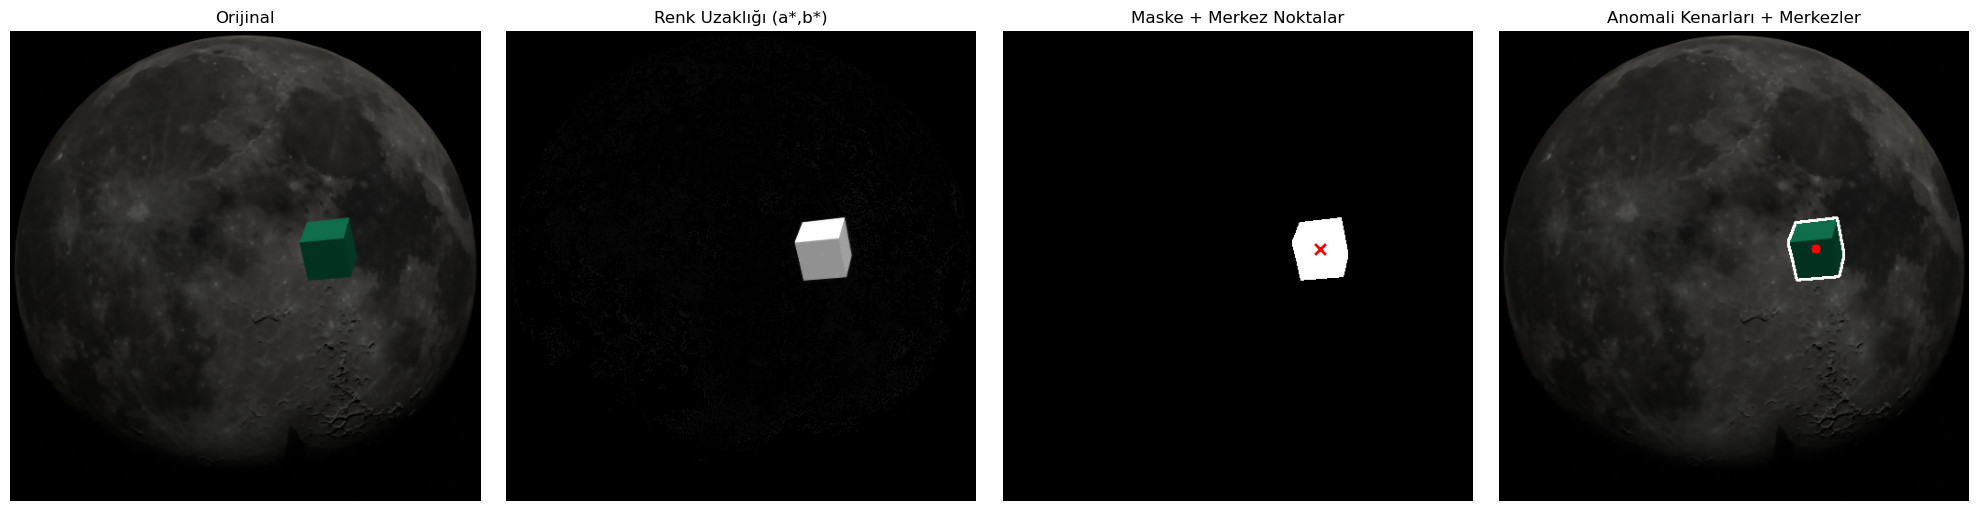

In [11]:
# ---- 6) Kontur çıkar, merkezleri bul ve çiz ----
# Konturlar (overlay için)
cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
overlay = img_rgb.copy()
cv2.drawContours(overlay, cnts, -1, (255, 255, 255), thickness=2)  # beyaz kenar

# Merkezleri (centroid) bul: temiz maskede bağlı bileşenler
num_labels2, labels2, stats2, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
centers = [(int(x), int(y)) for (x, y) in centroids[1:]]  # 0: arka plan, o yüzden atla

# Overlay üstüne kırmızı dolu noktalar
for (cx, cy) in centers:
    cv2.circle(overlay, (cx, cy), radius=5, color=(255, 0, 0), thickness=-1)

# ---- 7) Göster ----
plt.figure(figsize=(20,5))
plt.subplot(1,4,1); plt.imshow(img_rgb); plt.title("Orijinal"); plt.axis("off")
plt.subplot(1,4,2); plt.imshow(D_8u, cmap="gray"); plt.title("Renk Uzaklığı (a*,b*)"); plt.axis("off")

# Maske + merkezleri matplotlib ile işaretle
plt.subplot(1,4,3); 
plt.imshow(mask, cmap="gray"); 
if centers:
    xs, ys = zip(*centers)
    plt.scatter(xs, ys, s=60, c='red', marker='x', linewidths=2)
plt.title("Maske + Merkez Noktalar"); plt.axis("off")

plt.subplot(1,4,4); plt.imshow(overlay); plt.title("Anomali Kenarları + Merkezler"); plt.axis("off")
plt.tight_layout(); plt.show()
